In [1]:
from md4.configs.hollow_md4.text8 import get_config
from collections.abc import Callable, Mapping, Sequence
import copy
import functools
from typing import Any

from absl import logging
from clu import metric_writers
from clu import metrics
from clu import parameter_overview
from clu import periodic_actions
from etils import epath
import flax
import flax.jax_utils as flax_utils
import flax.linen as nn
import grain.python as graåçin
import jax
from jax.experimental import checkify
import jax.numpy as jnp
import ml_collections
import numpy as np
import optax
from orbax import checkpoint as orbax_checkpoint

from md4 import input_pipeline
from md4 import input_pipeline_v2
from md4 import sampling
from md4 import utils
from md4.models import utils as model_utils

from md4.train import *
from md4.train import _get_checkpoint_manager

import pickle
from tqdm import tqdm

config = get_config()
workdir = "/root/md4/data_dir/text8/expt_contantlr_deeper__model_untie"

2025-04-08 06:19:51.393020: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744093191.425155   68921 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744093191.435019   68921 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744093191.464271   68921 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744093191.464313   68921 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744093191.464322   68921 computation_placer.cc:177] computation placer alr

cv2 not found


In [2]:
workdir = epath.Path(workdir)
workdir.mkdir(parents=True, exist_ok=True)

rng = utils.get_rng(config.seed)
logging.info("Using random seed %s.", rng)
writer = metric_writers.create_default_writer(
    workdir, just_logging=jax.process_index() > 0
)

# Learning rate schedule.
assert config.batch_size % jax.device_count() == 0
per_device_batch_size = config.batch_size // jax.device_count()
num_train_steps = input_pipeline.get_num_train_steps(config)
steps_per_epoch = num_train_steps // config.num_epochs
logging.info("num_train_steps=%d, steps_per_epoch=%d", num_train_steps, steps_per_epoch)
schedule_fn = functools.partial(
    get_learning_rate,
    base_learning_rate=config.learning_rate,
    num_steps=num_train_steps,
    warmup_steps=config.warmup_steps,
    schedule_type=config.learning_rate_schedule,
)

# Build input pipeline.
rng, data_seed = jax.random.split(rng)
data_seed = int(
    jax.random.randint(data_seed, [], minval=0, maxval=np.iinfo(np.int32).max)
)
# The input pipeline runs on each process and loads data for local TPUs.
create_datasets = (
    input_pipeline_v2.create_datasets
    if config.get("use_v2_input_pipeline", None)
    else input_pipeline.create_datasets
)
train_loader, eval_loaders, dataset_info = create_datasets(config, data_seed)

train_iter = iter(train_loader)

# Initialize model.
rng, model_rng = jax.random.split(rng)
data_shape = input_pipeline.get_data_shape(config)
# Note: parameters are initialized in half precision if mixed_precision_training=True
# We could also try casting them to half precision here
model, optimizer, train_state, metrics_class = (
    create_train_state(  # pylint: disable=invalid-name
        config,
        model_rng,
        input_shape=(per_device_batch_size // config.num_microbatches,) + data_shape,
        schedule_fn=schedule_fn,
    )
)

# Set up checkpointing of the model and the input pipeline.
checkpoint_manager = _get_checkpoint_manager(config, workdir)

# Retrieve data from previous checkpoints if possible.
checkpointed_state = dict(train_state=train_state, train_iter=train_iter)
if checkpoint_manager.latest_step() is not None:
    checkpointed_state = checkpoint_manager.restore(
        checkpoint_manager.latest_step(), items=checkpointed_state
    )
train_state = checkpointed_state["train_state"]
train_iter = checkpointed_state["train_iter"]

I0000 00:00:1744093200.195098   68921 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78645 MB memory:  -> device: 0, name: NVIDIA H100 80GB HBM3, pci bus id: 0000:05:00.0, compute capability: 9.0
I0000 00:00:1744093200.197286   68921 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 78657 MB memory:  -> device: 1, name: NVIDIA H100 80GB HBM3, pci bus id: 0000:06:00.0, compute capability: 9.0
I0000 00:00:1744093200.199724   68921 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 78657 MB memory:  -> device: 2, name: NVIDIA H100 80GB HBM3, pci bus id: 0000:07:00.0, compute capability: 9.0
I0000 00:00:1744093200.201905   68921 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 78657 MB memory:  -> device: 3, name: NVIDIA H100 80GB HBM3, pci bus id: 0000:08:00.0, compute capability: 9.0
I0000 00:00:1744093200.204177   68921 gpu_device.cc:2019] Create

In [3]:
# Distribute training.
train_state = flax_utils.replicate(train_state)
train_step_func = functools.partial(
    train_step,
    model=model,
    optimizer=optimizer,
    train_metrics_class=metrics_class,
    learning_rate_fn=schedule_fn,
    ema_rate=config.ema_rate,
    num_microbatches=config.get("num_microbatches", None),
)
if config.check_nans:
    train_step_func = checkify.checkify(train_step_func, errors=checkify.float_checks)
p_train_step = jax.pmap(train_step_func, axis_name="batch", donate_argnums=(0,))
p_eval_step = jax.pmap(
    functools.partial(
        eval_step,
        model=model,
        eval_metrics_class=metrics_class,
        ema_rate=config.ema_rate,
    ),
    axis_name="batch",
)

hooks = []
report_progress = periodic_actions.ReportProgress(
    num_train_steps=num_train_steps, writer=writer
)
if jax.process_index() == 0:
    hooks += [
        report_progress,
        periodic_actions.Profile(num_profile_steps=5, logdir=workdir),
    ]
train_metrics = None

# Unreplicating from TPU is costly, so we only do it once at the start.
initial_step = int(flax.jax_utils.unreplicate(train_state.step))

In [4]:
batch = utils.reshape_batch(next(train_iter))

if config.check_nans:
    errs, (train_state, metrics_update) = p_train_step(
        train_state=train_state, batch=batch
    )
    errs.throw()
else:
    train_state, metrics_update = p_train_step(train_state=train_state, batch=batch)
metric_update = flax_utils.unreplicate(metrics_update)

train_metrics = (
    metric_update if train_metrics is None else train_metrics.merge(metric_update)
)

2025-04-08 06:21:01.714887: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-08 06:21:01.714885: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-08 06:21:01.714928: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744093261.729757   71614 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744093261.729876   71615 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:17440932

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
batch_size 64
cv2 not found


In [5]:
model.sampler = "maskgit"

results_dict = {}

tem_range = [.5,1.0,2.0,4.0,8.0,10.0,12.0,16.0,20.0,40.0]

# for k in k_range:
#     for tem in tem_range:
#         results_dict[k, tem] = {}

# timesteps = 256
# model.timesteps = timesteps // 2

for tem in tqdm(tem_range):
    for timesteps in tqdm([16, 32, 64, 128, 256]):
        model.timesteps = timesteps
        model.maskgit_temp = tem
        # for timesteps in tqdm([16, 32, 64, 128, 256]):
        #     model.timesteps = timesteps
        # with report_progress.timed("sample"):
        _, sample_rng = jax.random.split(rng)
        dummy_loader = train_loader
        dummy_batch = utils.reshape_batch(next(iter(dummy_loader)))
        dummy_inputs = dummy_batch[config.task_type]
        if "label" in dummy_batch:
            conditioning = dummy_batch["label"].astype("int32")
        else:
            conditioning = None

        samples = sampling.generate(
            model,
            train_state,
            flax_utils.replicate(sample_rng),
            dummy_inputs,
            conditioning=conditioning,
        )

        all_samples = jax.pmap(
            lambda x: jax.lax.all_gather(x, "batch"), axis_name="batch"
        )(samples)
        all_samples = flax_utils.unreplicate(all_samples)
        all_samples = all_samples.reshape(-1, *data_shape)

        tokenizer = dataset_info["tokenizer"]
        texts = utils.detokenize_texts(all_samples, tokenizer)
        results_dict[timesteps, tem] = texts

  0%|          | 0/10 [00:00<?, ?it/s]2025-04-08 06:22:59.694234: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744093379.709858   75950 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744093379.714899   75950 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744093379.728811   75950 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744093379.728839   75950 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744093379.728845   75950 computation

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not foundcv2 not found

cv2 not found


2025-04-08 06:23:56.931447: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744093436.946459   79305 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744093436.951244   79305 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744093436.963517   79305 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744093436.963544   79305 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744093436.963549   79305 computation_placer.cc:177] computation placer alr

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-04-08 06:24:49.145274: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-08 06:24:49.145274: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744093489.160581   81598 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744093489.160659   81600 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-08 06:24:49.161393: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:17440934

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not foundcv2 not found

cv2 not found


2025-04-08 06:25:46.739882: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-08 06:25:46.739881: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-08 06:25:46.739882: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-08 06:25:46.739894: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-08 06:25:46.746482: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for 

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-04-08 06:26:48.087108: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744093608.102565   86228 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-08 06:26:48.105937: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744093608.107517   86228 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744093608.120567   86228 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744093608.120593   86228 computation_pl

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


 10%|█         | 1/10 [05:08<46:12, 308.02s/it]2025-04-08 06:28:07.658463: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744093687.674155   88588 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744093687.679121   88588 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744093687.692790   88588 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744093687.692817   88588 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744093687.692822   88588 co

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not foundcv2 not found

cv2 not found


2025-04-08 06:28:59.017903: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-08 06:28:59.017904: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744093739.033304   90932 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744093739.033532   90938 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-08 06:28:59.036243: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:17440937

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-04-08 06:29:49.294494: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-08 06:29:49.298178: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744093789.309489   93410 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744093789.312897   93440 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744093789.314299   93410 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-08 06:29:49.314474: E external/local_xla/xla

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-04-08 06:30:46.863332: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744093846.879108   95647 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744093846.884335   95647 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-08 06:30:46.887386: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-08 06:30:46.887392: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-08 06:30:

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-04-08 06:31:53.031331: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744093913.046280   98031 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744093913.050943   98031 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744093913.063174   98031 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744093913.063204   98031 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744093913.063209   98031 computation_placer.cc:177] computation placer alr

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


 20%|██        | 2/10 [10:13<40:53, 306.69s/it]2025-04-08 06:33:13.479984: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744093993.502891  100412 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744093993.509031  100412 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744093993.527730  100412 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744093993.527766  100412 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744093993.527773  100412 co

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-04-08 06:34:04.808912: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744094044.824243  102743 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744094044.829211  102743 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744094044.842319  102743 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744094044.842347  102743 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744094044.842352  102743 computation_placer.cc:177] computation placer alr

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not foundcv2 not found



2025-04-08 06:34:57.352265: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744094097.370328  105068 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744094097.375093  105068 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744094097.388056  105068 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744094097.388083  105068 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744094097.388088  105068 computation_placer.cc:177] computation placer alr

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-04-08 06:35:54.877146: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-08 06:35:54.891002: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-08 06:35:54.891141: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744094154.893486  107448 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744094154.898470  107448 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000 00:00:17440

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not foundcv2 not found

cv2 not found
cv2 not found


2025-04-08 06:37:01.831556: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-08 06:37:01.835024: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-08 06:37:01.839820: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744094221.846792  109745 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744094221.850412  109750 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:17440942

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


 30%|███       | 3/10 [15:29<36:14, 310.62s/it]2025-04-08 06:38:28.658583: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-08 06:38:28.658893: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744094308.674169  112151 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744094308.674267  112167 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744094308.679087  112167 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-04-08 06:39:20.337717: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-08 06:39:20.349827: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744094360.353491  114366 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744094360.358608  114366 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744094360.371670  114366 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744094360.371696  114366 computation_pl

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-04-08 06:40:16.639127: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-08 06:40:16.646316: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744094416.654725  116962 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744094416.659498  116962 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000 00:00:1744094416.661200  116742 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744094416.665869  116742 cuda_blas.cc:1

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-04-08 06:41:12.523453: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744094472.538782  119229 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744094472.543608  119229 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744094472.555966  119229 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744094472.555999  119229 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744094472.556004  119229 computation_placer.cc:177] computation placer alr

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-04-08 06:42:20.017887: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-08 06:42:20.020289: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744094540.032795  121452 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744094540.035467  121380 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744094540.037530  121452 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000 00:00:1744094540.040254  121380 cuda_blas.cc:1

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


 40%|████      | 4/10 [20:44<31:15, 312.60s/it]2025-04-08 06:43:44.275669: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-08 06:43:44.278767: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-08 06:43:44.290462: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744094624.290486  123688 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-08 06:43:44.292601: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register 

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-04-08 06:44:35.346614: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744094675.361466  125958 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744094675.366113  125958 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-08 06:44:35.367962: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
W0000 00:00:1744094675.378019  125958 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744094675.378045  125958 computation_pl

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-04-08 06:45:27.059500: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-08 06:45:27.067648: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744094727.075002  128315 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-08 06:45:27.078605: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744094727.081660  128315 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000 00:00:17440

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-04-08 06:46:24.679430: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-08 06:46:24.679436: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-08 06:46:24.679434: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-08 06:46:24.694469: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744094784.694877  130685 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already b

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-04-08 06:47:36.609018: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744094856.625815  132995 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744094856.631239  132995 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744094856.646936  132995 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744094856.647381  132995 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744094856.647390  132995 computation_placer.cc:177] computation placer alr

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


 50%|█████     | 5/10 [26:14<26:33, 318.62s/it]2025-04-08 06:49:13.234984: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-08 06:49:13.247454: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744094953.250382  135353 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-08 06:49:13.256269: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744094953.258301  135353 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when on

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-04-08 06:50:07.271001: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744095007.286610  137648 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-08 06:50:07.288361: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744095007.291384  137648 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-08 06:50:07.294744: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:17440

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-04-08 06:51:02.092291: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744095062.106966  139884 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744095062.111644  139884 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744095062.123608  139884 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744095062.123639  139884 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744095062.123644  139884 computation_placer.cc:177] computation placer alr

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-04-08 06:51:59.515592: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744095119.530497  142332 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744095119.535384  142332 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-08 06:51:59.543584: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
W0000 00:00:1744095119.547778  142332 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744095119.547806  142332 computation_pl

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-04-08 06:53:07.013263: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744095187.031836  144602 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744095187.036674  144602 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-08 06:53:07.038516: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-08 06:53:07.038552: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
W0000 00:00:17440

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


 60%|██████    | 6/10 [31:34<21:16, 319.14s/it]2025-04-08 06:54:34.028052: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-08 06:54:34.028050: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-08 06:54:34.028049: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744095274.043198  147107 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744095274.043363  146933 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one h

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-04-08 06:55:26.583193: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744095326.598084  149191 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744095326.602879  149191 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744095326.617075  149191 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744095326.617103  149191 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744095326.617109  149191 computation_placer.cc:177] computation placer alr

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-04-08 06:56:18.577076: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744095378.592050  151547 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744095378.596830  151547 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744095378.609727  151547 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744095378.609752  151547 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744095378.609757  151547 computation_placer.cc:177] computation placer alr

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-04-08 06:57:11.470479: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744095431.486111  153866 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744095431.491237  153866 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744095431.504437  153866 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744095431.504463  153866 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744095431.504468  153866 computation_placer.cc:177] computation placer alr

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-04-08 06:58:19.958995: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-08 06:58:19.958996: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-08 06:58:19.959006: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744095499.974129  156199 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744095499.974125  156585 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:17440954

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


 70%|███████   | 7/10 [36:44<15:49, 316.40s/it]2025-04-08 06:59:44.110393: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744095584.126121  158518 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744095584.131378  158518 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744095584.144482  158518 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744095584.144516  158518 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744095584.144522  158518 co

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-04-08 07:00:12.383563: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744095612.398809  160758 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744095612.403915  160758 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-08 07:00:12.404112: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-08 07:00:12.404220: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
W0000 00:00:17440

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-04-08 07:01:07.598659: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744095667.615320  163036 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744095667.620251  163036 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744095667.635997  163036 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744095667.636036  163036 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744095667.636042  163036 computation_placer.cc:177] computation placer alr

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-04-08 07:02:04.235700: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-08 07:02:04.235710: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744095724.251592  165301 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744095724.251581  165300 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744095724.256414  165301 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000 00:00:1744095724.256421  165300 cuda_blas.cc:1

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-04-08 07:03:10.031298: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-08 07:03:10.031303: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744095790.046914  167647 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744095790.046945  167650 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744095790.051659  167647 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000 00:00:1744095790.051663  167650 cuda_blas.cc:1

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


 80%|████████  | 8/10 [40:36<09:38, 289.49s/it]2025-04-08 07:03:36.342450: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-08 07:03:36.342485: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744095816.357915  169922 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744095816.361865  169925 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744095816.362739  169922 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-04-08 07:04:26.834584: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744095866.850111  172284 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744095866.855001  172284 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744095866.868906  172284 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744095866.868936  172284 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744095866.868941  172284 computation_placer.cc:177] computation placer alr

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-04-08 07:05:21.550611: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744095921.566237  174842 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744095921.571029  174842 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744095921.583665  174842 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744095921.583695  174842 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744095921.583701  174842 computation_placer.cc:177] computation placer alr

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-04-08 07:06:21.123025: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744095981.138162  177061 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-08 07:06:21.139589: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744095981.142966  177061 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000 00:00:1744095981.155242  176881 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
W0000 00:00:1744095981.155535  177061 computation_pl

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-04-08 07:07:27.983990: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-08 07:07:27.993121: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744096048.000640  179158 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744096048.005604  179158 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000 00:00:1744096048.008125  179153 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744096048.012874  179153 cuda_blas.cc:1

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


 90%|█████████ | 9/10 [45:49<04:56, 296.61s/it]2025-04-08 07:08:48.284200: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-08 07:08:48.284114: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744096128.299084  181501 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744096128.299075  181496 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744096128.303846  181496 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-04-08 07:09:37.607092: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-08 07:09:37.607106: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744096177.622310  183775 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744096177.622542  183780 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-08 07:09:37.622693: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-08 07:09:37.

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-04-08 07:10:35.784650: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744096235.801425  186011 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744096235.806485  186011 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-08 07:10:35.815504: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
W0000 00:00:1744096235.824233  186011 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744096235.824267  186011 computation_pl

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-04-08 07:11:33.475466: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-08 07:11:33.475465: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-08 07:11:33.489625: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-08 07:11:33.490392: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744096293.491616  188300 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already b

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


2025-04-08 07:12:37.799522: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-08 07:12:37.802069: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744096357.814437  190919 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744096357.816924  190647 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744096357.819088  190919 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000 00:00:1744096357.821620  190647 cuda_blas.cc:1

cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found
cv2 not found


100%|██████████| 10/10 [51:03<00:00, 306.31s/it]


In [7]:
with open(
    f"/root/md4/data_dir/text8/maskgit_generations.pkl", "wb"
) as f:
    pickle.dump(results_dict, f)

In [8]:
with open("/root/md4/data_dir/text8/text8_vocab.pkl", "rb") as f:
    vocab = pickle.load(f)

In [9]:
acc_dict = {}

for timesteps, texts in results_dict.items():
    concated = " ".join(texts)
    generated_words = concated.split()
    len(texts), len(generated_words)

    # check if generated words are in vocab
    s = 0
    for word in tqdm(generated_words):
        if word in vocab:
            s += 1
    print(s / len(generated_words))
    acc_dict[timesteps] = s / len(generated_words)
with open("/root/md4/data_dir/text8/baseline_acc.pkl", "wb") as f:
    pickle.dump(acc_dict, f)

100%|██████████| 22911/22911 [00:19<00:00, 1200.77it/s]


0.7461044912923923


100%|██████████| 22837/22837 [00:17<00:00, 1287.36it/s]


0.8284363094977449


100%|██████████| 22896/22896 [00:17<00:00, 1340.16it/s]


0.8732092941998603


100%|██████████| 22897/22897 [00:16<00:00, 1371.37it/s]


0.89815259641001


100%|██████████| 22697/22697 [00:16<00:00, 1373.87it/s]

0.9017050711547782


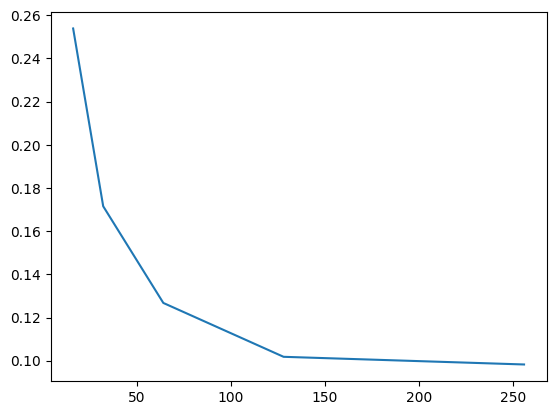

In [10]:
from matplotlib import pyplot as plt

plt.plot(np.array(list(acc_dict.keys())), 1 - np.array(list(acc_dict.values())))

In [11]:
model.sampler

'ancestral'